<a href="https://colab.research.google.com/github/pwolscho/unet/blob/master/u_net_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![U-Net Demonstration](https://drive.google.com/uc?id=1-kEr1EjJgpSjGCV1oFfYw_A2cnu5cNVI)

#Über dieses Notebook

U-Net ist die bekannteste Architektur im Bereich der Semantischen Segmentierung (Anwendung: Segmentierung in Bildern). Im Rahmen des Kurses Seminat-Deep-Learning der Hochschule Offenburg zeigt dieses Notebook eine mögliche Implementierung von U-Net und demonstriert dessen Anwendung anhand eines Beispiel-Datensatzes.

Informationen zum Datensatz
Mehrere Gebiete der Erde mit großen Öl- und Gasansammlungen haben auch riesige Salzlagerstätten unter der Oberfläche, d.h. dort wo Salz ist, wird vermutlich auch das wertvolle Öl zu finden sein.

Professionelle seismische Messungen zum Auffinden der Salzlagerstätten erfordert immer noch eine fachkundige menschliche Interpretation der daraus resultierenden Bilddaten. Dies führt zu sehr subjektiven, sehr variablen Ergebnissen. Das führt zu potenziell gefährlichen Situationen für Bohrer von Öl- und Gasunternehmen.

Um sehr präzise seismischen Bilder zu erstellen, hofft TGS-NOPEC Geophysical Systems (das weltweit führende Unternehmen für geophysikalische Dienste), dass die Online-Community von Kaggle in der Lage sein wird, einen Algorithmus zu entwickeln, der automatisch und genau erkennt, ob und Salz unter der Erdoberfläche zu finden ist oder nicht.

Dazu wurde im Jahr 2018 eine Wettbewerb von Kaggle durchgeführt.

Auf den diesem Notebook verwendete Datensatz kann nach wie vor unter https://www.kaggle.com/c/tgs-salt-identification-challenge/data zugegriffen werden.

Die Daten sind eine Reihe von seismischen Bildern von zufällig ausgewählten Orten der Erde. Die Bilder sind 101 x 101 Pixel groß und jedes Pixel wird entweder als Salz oder als Sediment klassifiziert. Zusätzlich zu den seismischen Bildern wird für jedes Bild die Tiefe der aufgenommenen Position angegeben.

##Gliederung des Notebooks

Die durchgeführten Schritte gliedern sich chronologisch wie folgt:

- Bereitstellung des Datensatzes
  - Zugriff auf die Kaggle-API
  - Download und Entpacken des Datensatzes
  - Skalierung der Trainigsbilder und Masken
- Definition des U-Net-Modells
- Training des U-Net-Modells
- Evaluierung des U-Net-Modells

#Bereitstellung des Datensatzes

##Zugriff auf die Kaggle-API

Um auf den Datensatz von Kaggle zugreifen zu können, wird die Kaggle-API (https://www.kaggle.com/docs/api) und einen persönlichen API-Token benötigt. Der API-Token kann im persönlichen Account von Kaggle generiert werden. Um den manuellen Upload (files.upload()) zu umgehen wird der Inhalt des Tokens hartkodiert.

In [0]:
kaggle_json = '{"username":"philipwolschon","key":"715ad801ca6728d6730b7c276db32c6f"}'

Zunächst wird die leere Datei kaggle.json angelegt und mit dem Inhalt des kaggle_json-Objekts (API-Token) befüllt.

In [0]:
import json

In [0]:
with open('kaggle.json', 'w') as file:
  json.dump(kaggle_json, file, ensure_ascii=False)

with open('kaggle.json', 'w') as file:
  file.write(kaggle_json)

Außerdem erwartet die Kaggle-API, dass der API-Token in ~/.kaggle/ (/root/.kaggle/) zu finden ist. Daher wird das Verzeichnis "kaggle" erstellt und der API-Token dort hin verschoben.

In [4]:
!pip install kaggle #Zugriff auf den Datensatz von Kaggle

In [0]:
!mkdir -p ~/.kaggle #Den Ordner anlegen
!mv kaggle.json ~/.kaggle/ #Den API-Token verschieben

Liefert folgende Funktion True zurück wurde die erforderliche Datei im korrekten Verzeichnis der VM erstellt (eine manuelle Prüfung ist nicht möglich, da der Zugriff auf das root-Verzeichnis der VM eingeschränkt ist).

In [0]:
import os

In [7]:
os.path.isfile("/root/.kaggle/kaggle.json")

True

Um Warnungen beim Starten von Kaggle-Tools zu vermeiden werdem dem Besitzer der Datei Lese- und Schreibrechte gewährt.

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

##Download und Entpacken des Datensatzes

Mit Hilfe der Kaggle-API kann nun das Datenset heruntergeladen werden.

In [9]:
!kaggle competitions download -c tgs-salt-identification-challenge -p /content/salt_data

depths.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
flamingo.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
competition_data.zip: Skipping, found more recently modified local copy (use --force to force download)


Die Trainigsdaten sind komprimiert und müssen zunächst entpackt werden. Zu den Testdaten sind keine Masken vorhanden, weswegen diese nicht weiter verwendet werden.

In [0]:
from zipfile import ZipFile

In [0]:
with ZipFile('/content/salt_data/train.zip', 'r') as zipObj:
   zipObj.extractall('/content/salt_data/train')

In [0]:
train_path = '/content/salt_data/train'

##Skalierung der Trainigsbilder und Masken

In [0]:
import numpy as np
from skimage.transform import resize
from tqdm import tqdm
from keras.preprocessing.image import img_to_array, load_img, array_to_img

In [0]:
def get_scaled_X_y_data(path, img_width, img_height):
    output_shape = (128, 128, 1) #Size of the generated output image (rows, cols[, …][, dim])

    ids = os.listdir(path + '/images')
    X = np.zeros((len(ids), img_height, img_width, 1), dtype=np.float32)
    y = np.zeros((len(ids), img_height, img_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')

    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/images/' + id_, color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, output_shape, mode='constant', preserve_range=True)

        # Load masks
        mask = img_to_array(load_img(path + '/masks/' + id_, color_mode = "grayscale"))
        mask = resize(mask, output_shape, mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        y[n] = mask / 255

    print('Done!')
    
    return X, y

##Data Augmentation

In [0]:
# Importing necessary functions 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 

In [0]:
def get_augmented_X_y_data(X, y, do_augmentation):
    if (do_augmentation == True):
        data_gen_args = dict(horizontal_flip=True, vertical_flip=False)
    else:
        data_gen_args = dict()
    
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    seed = 2020
    bs = 32

    image_generator = image_datagen.flow(X, seed=seed, batch_size=bs, shuffle=True, save_to_dir='/content/salt_data/train/images_data_aug')
    mask_generator = mask_datagen.flow(y, seed=seed, batch_size=bs, shuffle=True, save_to_dir='/content/salt_data/train/masks_data_aug')

    # Just zip the two generators to get a generator that provides augmented images and masks at the same time
    image_mask_generator = zip(image_generator, mask_generator)

    return image_mask_generator

#Definition des U-Net-Netzwerks

##Evaluierungsmetrik

In [0]:
import tensorflow as tf
from keras import backend as K

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

##Architektur

In [0]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.optimizers import Adam

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
  
    # contracting path

    # 128 -> 64
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    # 64 -> 32
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    # 32 -> 16
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    # 16 -> 8
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    # middle
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path

    # 8 -> 16
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    # 16 -> 32
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    # 32 -> 64
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    # 64 -> 128
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [29]:
input_img = Input((128, 128, 1), name='img')
model_standard = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model_data_aug = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model_standard.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[mean_iou])
model_data_aug.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[mean_iou])

model_standard.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_191 (Conv2D)             (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_181 (BatchN (None, 128, 128, 16) 64          conv2d_191[0][0]                 
__________________________________________________________________________________________________
activation_181 (Activation)     (None, 128, 128, 16) 0           batch_normalization_181[0][0]    
___________________________________________________________________________________________

#Training der U-Net-Modelle

##Daten in Train, Valid und Test aufteilen

In [0]:
from sklearn.model_selection import train_test_split

In [31]:
X, y = get_scaled_X_y_data(train_path, 128, 128)

  1%|          | 22/4000 [00:00<00:18, 215.91it/s]

Getting and resizing images ... 


100%|██████████| 4000/4000 [00:18<00:00, 220.08it/s]

Done!


In [0]:
# Split X and y into random train_valid and test
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.10, random_state=1234)

# Split X_train_valid and y_train_valid into random train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.222, random_state=2345)

##U-Net-Modell ohne Data Augmentation

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks_standard = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_standard.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [34]:
results_standard = model_standard.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks_standard,
                    validation_data=(X_valid, y_valid))



Train on 2800 samples, validate on 800 samples
Epoch 1/100
2800/2800 [==============================] - 28s 10ms/step - loss: 0.5002 - mean_iou: 0.4852 - val_loss: 0.5015 - val_mean_iou: 0.5616

Epoch 00001: val_loss improved from inf to 0.50152, saving model to model_standard.h5
Epoch 2/100
2800/2800 [==============================] - 17s 6ms/step - loss: 0.3298 - mean_iou: 0.5966 - val_loss: 0.9979 - val_mean_iou: 0.6166

Epoch 00002: val_loss did not improve from 0.50152
Epoch 3/100
2800/2800 [==============================] - 16s 6ms/step - loss: 0.2930 - mean_iou: 0.6299 - val_loss: 1.0058 - val_mean_iou: 0.6384

Epoch 00003: val_loss did not improve from 0.50152
Epoch 4/100
2800/2800 [==============================] - 16s 6ms/step - loss: 0.2648 - mean_iou: 0.6472 - val_loss: 0.2670 - val_mean_iou: 0.6563

Epoch 00004: val_loss improved from 0.50152 to 0.26701, saving model to model_standard.h5
Epoch 5/100
2800/2800 [==============================] - 16s 6ms/step - loss: 0.2413

In [0]:
import matplotlib.pyplot as plt

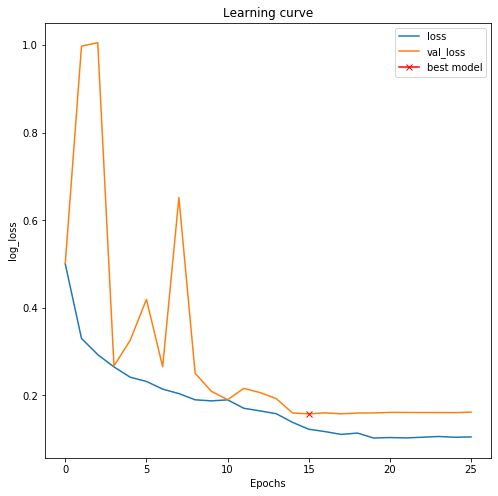

In [36]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results_standard.history["loss"], label="loss")
plt.plot(results_standard.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results_standard.history["val_loss"]), np.min(results_standard.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

##U-Net-Modell mit Data Augmentation

In [0]:
callbacks_data_aug = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint('model_data_aug.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
train_generator = get_augmented_X_y_data(X_train, y_train, do_augmentation=True)

In [39]:
results_data_aug = model_data_aug.fit_generator(train_generator, steps_per_epoch=(len(X_train) // 32), epochs=100, callbacks=callbacks_data_aug,
                              validation_data=(X_valid, y_valid))

Epoch 1/100
87/87 [==============================] - 26s 295ms/step - loss: 0.4544 - mean_iou: 0.4641 - val_loss: 0.3925 - val_mean_iou: 0.5366

Epoch 00001: val_loss improved from inf to 0.39249, saving model to model_data_aug.h5
Epoch 2/100
87/87 [==============================] - 17s 191ms/step - loss: 0.3206 - mean_iou: 0.5640 - val_loss: 0.4819 - val_mean_iou: 0.5948

Epoch 00002: val_loss did not improve from 0.39249
Epoch 3/100
87/87 [==============================] - 17s 193ms/step - loss: 0.2897 - mean_iou: 0.6152 - val_loss: 0.4809 - val_mean_iou: 0.6277

Epoch 00003: val_loss did not improve from 0.39249
Epoch 4/100
87/87 [==============================] - 17s 193ms/step - loss: 0.2676 - mean_iou: 0.6397 - val_loss: 0.2946 - val_mean_iou: 0.6484

Epoch 00004: val_loss improved from 0.39249 to 0.29462, saving model to model_data_aug.h5
Epoch 5/100
87/87 [==============================] - 17s 193ms/step - loss: 0.2474 - mean_iou: 0.6575 - val_loss: 0.3302 - val_mean_iou: 0.664

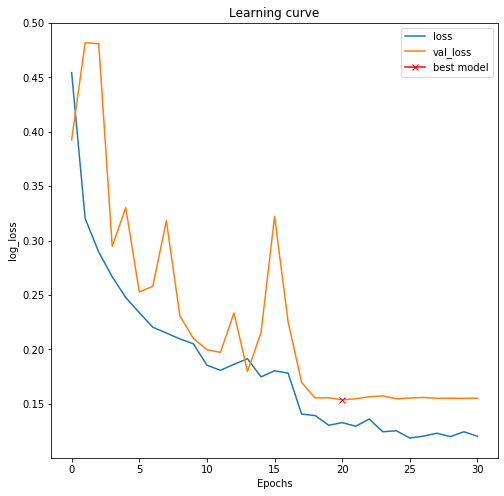

In [40]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results_data_aug.history["loss"], label="loss")
plt.plot(results_data_aug.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results_data_aug.history["val_loss"]), np.min(results_data_aug.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

#Evaluation der U-Net-Modelle

##U-Net-Modell ohne Data Augmentation

In [0]:
# Load best model
model_standard.load_weights('model_standard.h5')

In [42]:
# Evaluate on train set (this must be equals to the best log_loss)
model_standard.evaluate(X_train, y_train, verbose=1)

2800/2800 [==============================] - 6s 2ms/step


[0.10558202234762055, 0.7870092259134565]

In [43]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_standard.evaluate(X_valid, y_valid, verbose=1)

800/800 [==============================] - 2s 2ms/step


[0.15760632753372192, 0.7879916667938233]

In [44]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_standard.evaluate(X_test, y_test, verbose=1)

400/400 [==============================] - 1s 2ms/step


[0.13292190164327622, 0.7882483315467834]

In [45]:
# Predict on train, val and test
preds_train = model_standard.predict(X_train, verbose=1)
preds_val = model_standard.predict(X_valid, verbose=1)
preds_test = model_standard.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

400/400 [==============================] - 1s 1ms/step


In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

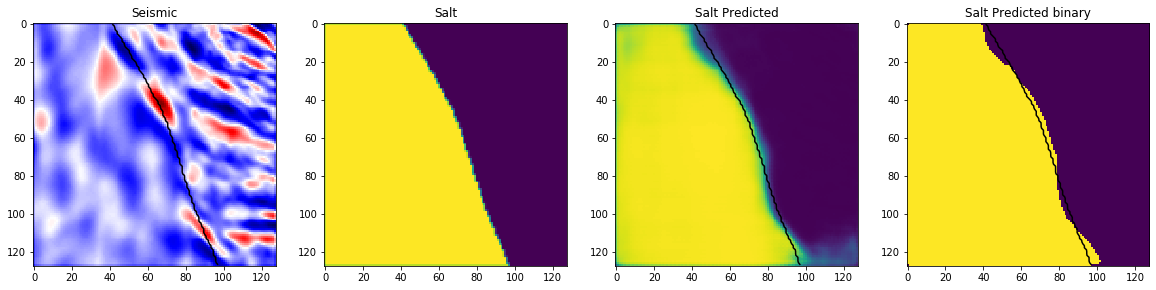

In [73]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=10)

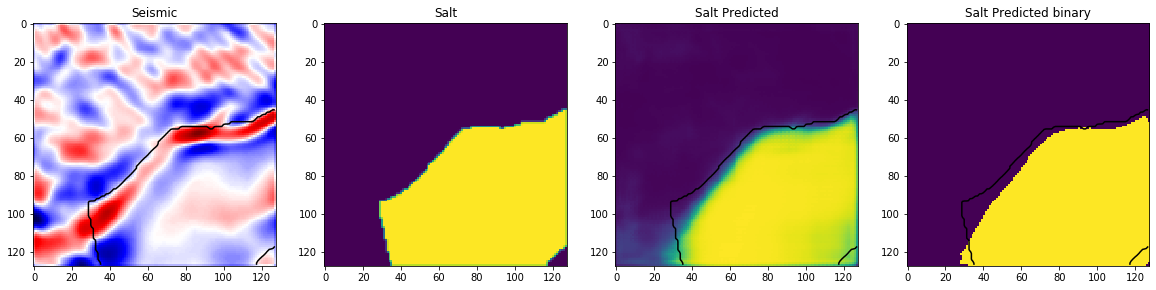

In [48]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)

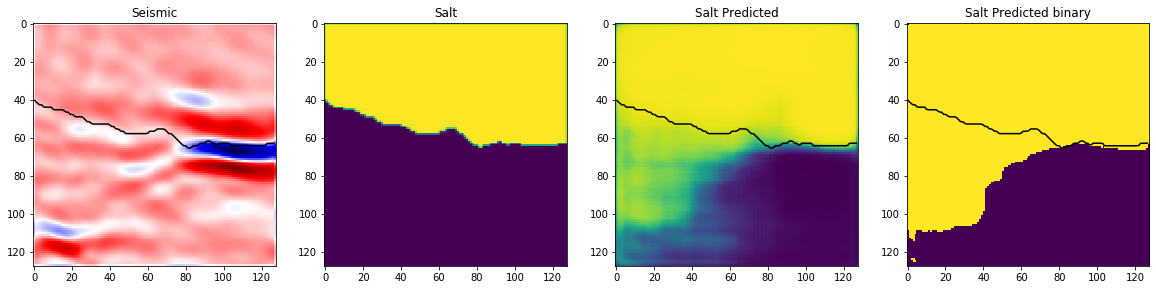

In [49]:
# Check if test data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=17)

##U-Net-Modell mit Data Augmentation

In [0]:
# Load best model
model_data_aug.load_weights('model_data_aug.h5')

In [51]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_data_aug.evaluate(X_train, y_train, verbose=1)

2800/2800 [==============================] - 6s 2ms/step


[0.11605781857456479, 0.7823975726536342]

In [52]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_data_aug.evaluate(X_valid, y_valid, verbose=1)

800/800 [==============================] - 2s 2ms/step


[0.15353499084711075, 0.7832764124870301]

In [72]:
# Evaluate on test set (this must be equals to the best log_loss)
model_data_aug.evaluate(X_test, y_test, verbose=1)

400/400 [==============================] - 1s 2ms/step


[0.1253035581111908, 0.7837709379196167]

In [54]:
# Predict on train, val and test
preds_train_data_aug = model_data_aug.predict(X_train, verbose=1)
preds_val_data_aug = model_data_aug.predict(X_valid, verbose=1)
preds_test_data_aug = model_data_aug.predict(X_test, verbose=1)

# Threshold predictions
preds_train_data_aug_t = (preds_train_data_aug > 0.5).astype(np.uint8)
preds_val_data_aug_t = (preds_val_data_aug > 0.5).astype(np.uint8)
preds_test_data_aug_t = (preds_test_data_aug > 0.5).astype(np.uint8)

400/400 [==============================] - 1s 1ms/step


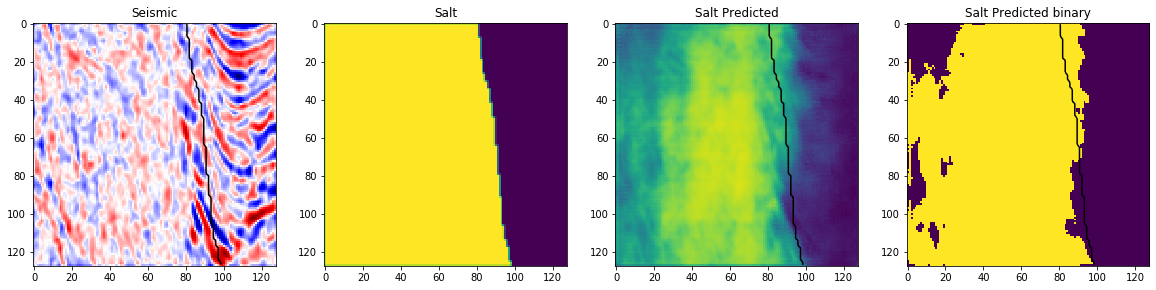

In [100]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train_data_aug, preds_train_data_aug_t, ix=14)

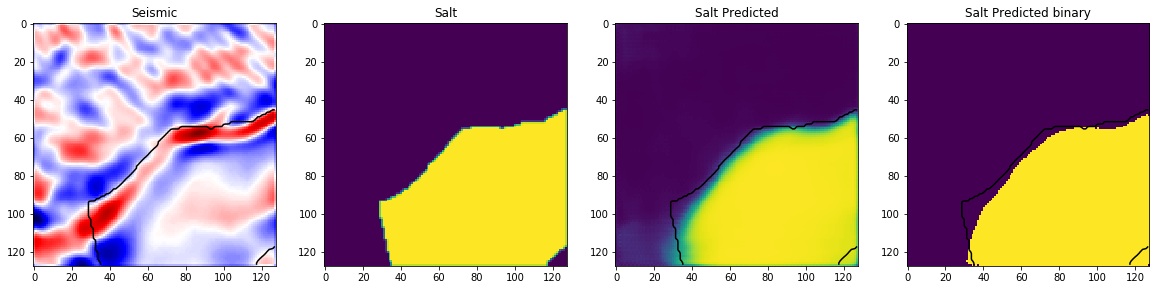

In [86]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val_data_aug, preds_val_data_aug_t, ix=15)

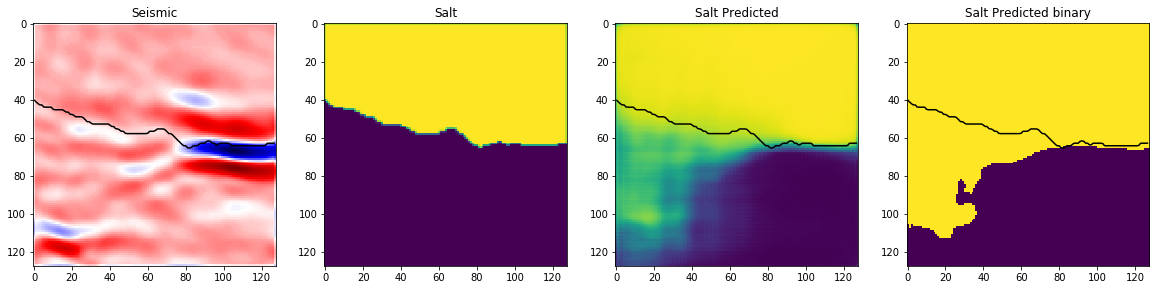

In [59]:
# Check if test data looks all right
plot_sample(X_test, y_test, preds_test_data_aug, preds_test_data_aug_t, ix=17)

In [70]:
image_number = 1
mean_iou(X_test, preds_test_data_aug)

AttributeError: ignored

In [84]:
image_number = 15

intersection = np.logical_and(y_test[image_number], preds_test_data_aug[image_number])
union = np.logical_or(y_test[image_number], preds_test_data_aug[image_number])
iou_score = np.sum(intersection) / np.sum(union)

print('intersection: %.6f' % np.sum(intersection))
print('union: %.6f' % np.sum(union))

print('iou_score: %.6f' % (iou_score))

intersection: 0.000000
union: 16384.000000
iou_score: 0.000000


In [85]:
intersection = np.logical_and(y_test[image_number], preds_test[image_number])
union = np.logical_or(y_test[image_number], preds_test[image_number])
iou_score = np.sum(intersection) / np.sum(union)

print('intersection: %.6f' % np.sum(intersection))
print('union: %.6f' % np.sum(union))

print('iou_score: %.6f' % (iou_score))

intersection: 0.000000
union: 16384.000000
iou_score: 0.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: No contour levels were found within the data range.
  import sys


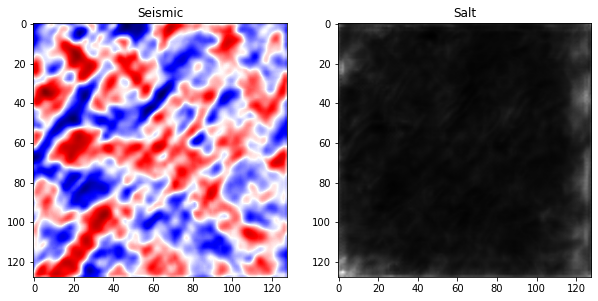

In [106]:
# Check if training data looks all right
has_mask = preds_test[image_number].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(X_test[image_number, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(preds_test[image_number].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(preds_test[image_number].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

##Threshold-Optimierung

In [0]:
from tqdm import tqdm_notebook

In [0]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [91]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid, np.int32(preds_val > threshold)) for threshold in tqdm_notebook(thresholds)])

In [0]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

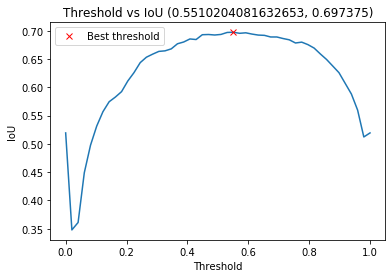

In [94]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

##U-Net-Modell mit Data Augmentation und optimiertem Threshold

In [0]:
# Threshold predictions
preds_train_data_aug_t_best = (preds_train_data_aug > threshold_best).astype(np.uint8)
preds_val_data_aug_t_best = (preds_val_data_aug > threshold_best).astype(np.uint8)
preds_test_data_aug_t_best = (preds_test_data_aug > threshold_best).astype(np.uint8)

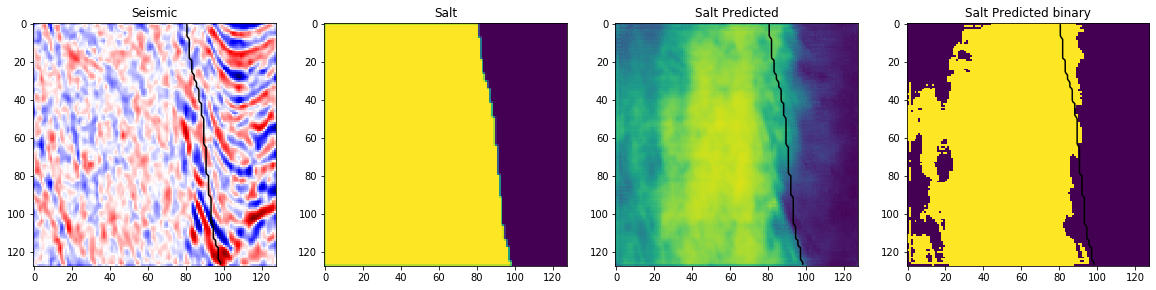

In [103]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train_data_aug, preds_train_data_aug_t_best, ix=14)

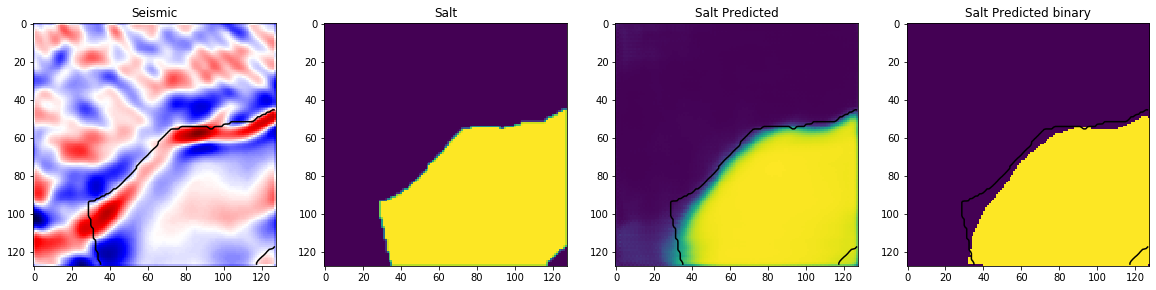

In [104]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val_data_aug, preds_val_data_aug_t_best, ix=15)

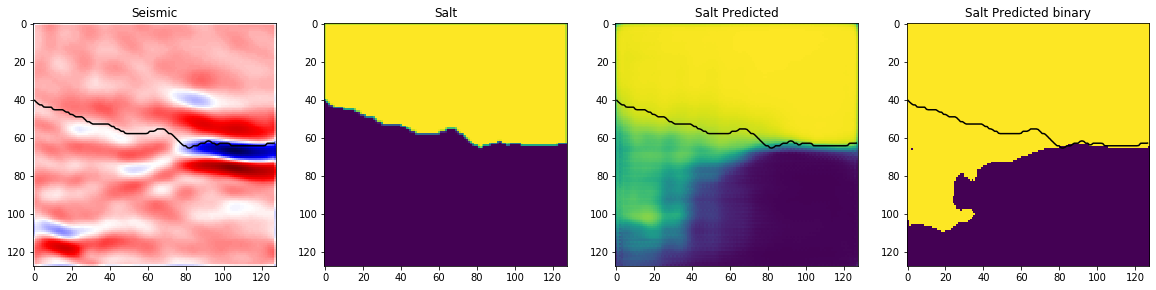

In [105]:
# Check if test data looks all right
plot_sample(X_test, y_test, preds_test_data_aug, preds_test_data_aug_t_best, ix=17)